In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random

# Open historical data provided by Kapriz management

In [2]:
new_prices=pd.read_csv('Dynamic_tarifs.csv',index_col='Category/occupancy')

In [3]:
data=pd.read_csv('histdata.csv')

In [4]:
fixed_rates=pd.read_csv('fixed_tariffs.csv')

# Assumptions

## Number of nights distribution (length). Day of the start of the booking distribution (day). Category choice (category).

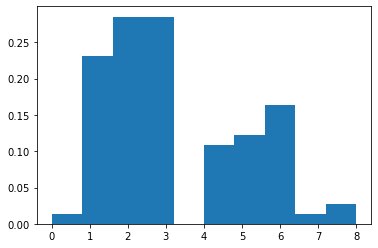

In [5]:
#model the lenght of stay  (number of nights) based on historical data and our expert intuition
modelled_list=[]
for i in range(92):
    modelled_list.extend(np.random.gamma(3, 1, 1).round())
plt.hist(modelled_list,density=True)
plt.show()

In [22]:
#get probability of selling the room starting from particular day of 90 days interval
def get_probability_of_day():
    number_of_guests = np.array(data['Number of guests arrived'])
    day_probability = number_of_guests / np.sum(number_of_guests)
    return list(day_probability)
day_probability=get_probability_of_day()

In [7]:
#get the day and the length values
def get_random_day_and_length():
    booking_length_prob = np.random.gamma(3, 1, 1).round()
    day=random.choices(range(0,92), weights=day_probability)[0]
    length=int(booking_length_prob[0])
    #avoid getting beyond the booking period
    if day+length>91:
        length=1
    return (day,length)

In [8]:
#what is the probability of guest choosing particular category (twim, villa, suit)?
#it is based on intuition and historical data
probab_list_for_each_category=[0.02,0.4,0.04,0.07,0.01,0.1,0.3,0.05,0.01]
def get_random_category():
    #9 is the number of categories
    return random.choices(range(0,9), weights=probab_list_for_each_category)[0]

# Updating calendar

In [9]:
#initialize the calendar based on max capacity
def get_availiable_rooms():
    rooms_count = np.repeat(new_prices[["Number of rooms"]].to_numpy(), 1)
    #available rooms in a day
    av_rooms_day = np.tile(rooms_count, (92, 1))
    return av_rooms_day

In [10]:
#do we have enough rooms for the days and category guest requested?
def check_availability(day,length,category):
    avail_list=[av_rooms_day[d,category] for d in range(day,day+length)]
    if any(n ==0 for n in avail_list):
        print('Sorry, no available rooms for your date') 
        return False
    else:
        return True

In [11]:
#now let's book available rooms and update calendar (available rooms decrease by 1)
#store the revenue as global variable
def get_price_for_request_and_confirm_booking(day,length,category,total_rooms_for_sale=117):
    global revenue
    global av_rooms_day
    check=check_availability(day,length,category)
    ##################calculate the price per each night based on occupancy
    if check==True: 
        occup_rate_list=[]
        actual_prices=[]
        for i in range(len(av_rooms_day)):
            occup_rate=1-np.sum(av_rooms_day[i])/total_rooms_for_sale
            occup_rate_list.append(occup_rate)
            if occup_rate<0.15:
                price_that_day=np.array(new_prices.iloc[:,1])
            elif occup_rate>=0.15 and occup_rate<0.45:
                price_that_day=np.array(new_prices.iloc[:,2])
            elif occup_rate>=0.45 and occup_rate<0.70:
                    price_that_day=np.array(new_prices.iloc[:,3])
            elif occup_rate>=0.70 and occup_rate<0.89:
                    price_that_day=np.array(new_prices.iloc[:,4])
            elif occup_rate>=0.89 and occup_rate<=1.00:
                    price_that_day=np.array(new_prices.iloc[:,5])
            actual_prices.append(price_that_day)
        booking_price=0
        ############## confirm booking and calculate revenue
        for night in range(day,day+length):
            booking_price=booking_price+actual_prices[night][category]
            av_rooms_day[night,category]=av_rooms_day[night,category]-1
        print('The price for your booking is',booking_price)
        revenue=revenue+booking_price
        return booking_price
    else:
        print('Request was cancelled')

In [12]:
#Similar function for the fixed model
def get_price_for_request_and_confirm_booking_fixed_price(day,length,category):
    global revenue
    global av_rooms_day
    check=check_availability(day,length,category)
    #calculate the price per each night based on occupancy
    if check==True: 
        actual_prices=[]
        for i in range(len(av_rooms_day)):
            if day <=20:
                price_that_day=np.array(fixed_rates.iloc[:,0])
            elif day >20 and day <=34:
                price_that_day=np.array(fixed_rates.iloc[:,1])
            elif day >34 and day <=84:
                price_that_day=np.array(fixed_rates.iloc[:,2])
            elif day >84:
                price_that_day=np.array(fixed_rates.iloc[:,3])
            actual_prices.append(price_that_day) 
        booking_price=0
        for night in range(day,day+length):
            booking_price=booking_price+actual_prices[night][category]
            av_rooms_day[night,category]=av_rooms_day[night,category]-1
        print('The price for your booking is',booking_price)
        revenue=revenue+booking_price
        return booking_price
    else:
        print('Request was cancelled')

# Putting things together

In [13]:
def next_booking_fixed():
    day_probability = get_probability_of_day()
    day_and_length=get_random_day_and_length()
    length=day_and_length[1]
    day=day_and_length[0]
    category=get_random_category() 
    get_price_for_request_and_confirm_booking_fixed_price(day,length,category)

In [14]:
def next_booking_dynamic():
    day_probability = get_probability_of_day()
    day_and_length=get_random_day_and_length()
    length=day_and_length[1]
    day=day_and_length[0]
    category=get_random_category()
    get_price_for_request_and_confirm_booking(day,length,category) 

In [15]:
#calculate resulting occupancy
def get_occupancy(av_rooms_day):
    rates_occupancy=[]
    for i in range(92):
        rates_occupancy.append(1-np.sum(av_rooms_day[i])/117)
    return rates_occupancy

In [16]:
#Initialize global variables for dynamic model
revenue=0
av_rooms_day = get_availiable_rooms()

In [24]:
number_of_requests=2000
for i in range(number_of_requests):
    next_booking_dynamic()

The price for your booking is 507
The price for your booking is 270
The price for your booking is 378
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 1197
The price for your booking is 678
The price for your booking is 258
The price for your booking is 714
The price for your booking is 111
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 847
The price for your booking is 738
The price for your booking is 240
The price for your booking is 399
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 0
The price for your booking is 258
The price for your booking is 1028
The price for your booking is 0
The price for your booking is 326
The price for your booking is 283
The price for your booking is 1039
The price for your booking is 414
The price f

The price for your booking is 270
The price for your booking is 774
The price for your booking is 282
The price for your booking is 428
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 1396
The price for your booking is 326
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 540
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 932
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 466
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 351
The price for your booking is 189
The price for your booking is 714
The price for your booking is 411
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 240
The price for your booking 

The price for your booking is 282
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 1617
The price for your booking is 163
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 141
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 129
The price for your booking is 270
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 270
The price for your booking is 297
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 515
The price for your booking is 0
The price for your booking is 129
The pri

The price for your booking is 841
The price for your booking is 290
The price for your booking is 89
The price for your booking is 270
The price for your booking is 222
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 86
The price for your booking is 129
The price for your booking is 698
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 439
The price for your booking is 1314
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 282
The price for your booking is 568
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 935
The price for your booking is 258
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is

The price for your booking is 207
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 378
The price for your booking is 258
The price for your booking is 207
The price for your booking is 423
The price for your booking is 528
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 222
The price for your booking is 2535
The price for your booking is 290
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 376
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 0
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 1009
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 282
Sorry, no available rooms for your date
Request was cancelled
Sorry, no available rooms for your date
Request was cancelled


KeyboardInterrupt: 

In [ ]:
print ('Revenue for dynamic price is ',revenue)

In [ ]:
np.mean(get_occupancy(av_rooms_day))

In [18]:
#Initialize global variables for fixed model
revenue=0
av_rooms_day = get_availiable_rooms()

In [23]:
#Run the fixed model
for i in range(number_of_requests):
    next_booking_fixed()

The price for your booking is 1014
The price for your booking is 115
The price for your booking is 1690
The price for your booking is 294
The price for your booking is 1690
The price for your booking is 676
The price for your booking is 1566
The price for your booking is 756
The price for your booking is 625
The price for your booking is 210
The price for your booking is 468
The price for your booking is 663
The price for your booking is 125
The price for your booking is 294
The price for your booking is 2028
The price for your booking is 1134
The price for your booking is 588
The price for your booking is 294
The price for your booking is 1014
The price for your booking is 676
The price for your booking is 115
The price for your booking is 676
The price for your booking is 125
The price for your booking is 567
The price for your booking is 375
The price for your booking is 1352
The price for your booking is 1352
The price for your booking is 2028
The price for your booking is 115
The 

The price for your booking is 345
The price for your booking is 125
The price for your booking is 375
The price for your booking is 312
The price for your booking is 338
The price for your booking is 250
The price for your booking is 500
The price for your booking is 125
The price for your booking is 105
The price for your booking is 1352
The price for your booking is 345
The price for your booking is 115
The price for your booking is 1881
The price for your booking is 1690
The price for your booking is 1014
The price for your booking is 1014
The price for your booking is 189
The price for your booking is 588
The price for your booking is 230
The price for your booking is 756
The price for your booking is 250
The price for your booking is 690
The price for your booking is 168
The price for your booking is 250
The price for your booking is 500
The price for your booking is 378
The price for your booking is 663
The price for your booking is 575
The price for your booking is 250
The price

The price for your booking is 336
The price for your booking is 1566
The price for your booking is 250
The price for your booking is 756
The price for your booking is 588
The price for your booking is 1176
The price for your booking is 375
The price for your booking is 945
The price for your booking is 0
The price for your booking is 2028
The price for your booking is 250
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 1470
The price for your booking is 125
The price for your booking is 480
The price for your booking is 1352
The price for your booking is 625
The price for your booking is 945
The price for your booking is 345
The price for your booking is 375
The price for your booking is 588
The price for your booking is 840
The price for your booking is 1014
The price for your booking is 945
The price for your booking is 1014
The price for your booking is 250
The price for your booking is 338
The price for your booking is 125
The price for y

The price for your booking is 136
The price for your booking is 945
The price for your booking is 204
The price for your booking is 1014
The price for your booking is 1014
The price for your booking is 960
The price for your booking is 345
The price for your booking is 676
The price for your booking is 500
The price for your booking is 676
The price for your booking is 345
The price for your booking is 676
The price for your booking is 345
The price for your booking is 336
The price for your booking is 442
The price for your booking is 250
The price for your booking is 243
The price for your booking is 884
The price for your booking is 189
The price for your booking is 567
The price for your booking is 1014
The price for your booking is 378
The price for your booking is 1352
The price for your booking is 375
The price for your booking is 663
The price for your booking is 504
The price for your booking is 115
The price for your booking is 676
The price for your booking is 336
The price 

The price for your booking is 125
The price for your booking is 125
The price for your booking is 250
The price for your booking is 210
The price for your booking is 500
The price for your booking is 250
The price for your booking is 375
The price for your booking is 1470
The price for your booking is 338
The price for your booking is 567
The price for your booking is 294
The price for your booking is 250
The price for your booking is 378
The price for your booking is 250
The price for your booking is 676
The price for your booking is 1352
The price for your booking is 676
The price for your booking is 125
The price for your booking is 504
The price for your booking is 625
The price for your booking is 960
The price for your booking is 204
The price for your booking is 375
The price for your booking is 378
The price for your booking is 945
The price for your booking is 115
The price for your booking is 375
The price for your booking is 115
The price for your booking is 230
The price fo

The price for your booking is 945
The price for your booking is 1000
The price for your booking is 375
The price for your booking is 336
The price for your booking is 375
The price for your booking is 345
The price for your booking is 1176
The price for your booking is 250
The price for your booking is 272
The price for your booking is 0
The price for your booking is 250
The price for your booking is 250
The price for your booking is 882
The price for your booking is 480
The price for your booking is 1352
The price for your booking is 1176
The price for your booking is 663
The price for your booking is 504
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 136
The price for your booking is 345
The price for your booking is 68
The price for your booking is 805
The price for your booking is 375
The price for your booking is 625
The price for your booking is 1352
The price for your booking is 230
The price for your booking is 1014
The price for you

The price for your booking is 676
The price for your booking is 230
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 296
The price for your booking is 945
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 378
The price for your booking is 884
The price for your booking is 588
The price for your booking is 125
The price for your booking is 345
The price for your booking is 1014
The price for your booking is 750
The price for your booking is 1352
The price for your booking is 338
The price for your booking is 2028
The price for your booking is 2366
The price for your booking is 522
The price for your booking is 375
The price for your booking is 1105
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 1176
The price for your booking is 882
The price for your booking is 375
The price for your booking is 2028
The price for your booking is 338
The price for your bookin

The price for your booking is 125
The price for your booking is 250
The price for your booking is 125
The price for your booking is 567
The price for your booking is 336
The price for your booking is 690
The price for your booking is 756
The price for your booking is 125
The price for your booking is 375
The price for your booking is 338
The price for your booking is 378
The price for your booking is 375
The price for your booking is 250
The price for your booking is 500
The price for your booking is 676
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 2366
The price for your booking is 1014
The price for your booking is 250
The price for your booking is 230
The price for your booking is 1014
The price for your booking is 567
The price for your booking is 1000
The price for your booking is 500
The price for your booking is 250
The price for your booking is 500
The price for your booking is 672
The price for your booking is 204
The price for yo

The price for your booking is 338
The price for your booking is 250
The price for your booking is 625
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 0
The price for your booking is 676
The price for your booking is 625
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 676
The price for your booking is 1014
The price for your booking is 575
Sorry, no available rooms for your date
Request was cancelled
The price for your booking is 945
The price for your booking is 676
The price for your booking is 146
The price for your booking is 567
The price for your booking is 191
The price for your booking is 250
The price for your booking is 500
The price for your booking is 250
The price for your booking is 250
The price for your booking is 1690
The price for your booking is 68
The price for your booking is 504
The price for your booking is 336
The price for your booking is 1014
The price for your booking is 23

In [20]:
print ('Revenue for fixed price is ',revenue)

Revenue for fixed price is  0


In [21]:
np.mean(get_occupancy(av_rooms_day))

0.0